# 6DoF Pose Estimation with Ultrasound Frames and IMU Data


## 1. Import Libraries


In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## 2. Load and Preprocess Data


In [2]:
def load_data(file_path):
    return pd.read_hdf(file_path)


file_path = "scans/20240826/wrist_data.h5"
df = load_data(file_path)

In [3]:
df.head()

,timestamp,frame,imu_acc_x,imu_acc_y,imu_acc_z,imu_orientation_x,imu_orientation_y,imu_orientation_z,ot_pos_x,ot_pos_y,ot_pos_z,ot_qw,ot_qx,ot_qy,ot_qz
0,2024-08-14 14:04:53.612948,"[[[35, 38, 38], [41, 44, 44], [54, 57, 57], [5...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646
1,2024-08-14 14:04:53.712948,"[[[35, 38, 38], [41, 44, 44], [54, 57, 57], [5...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646
2,2024-08-14 14:04:53.812948,"[[[35, 38, 38], [41, 44, 44], [54, 57, 57], [5...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646
3,2024-08-14 14:04:53.912948,"[[[41, 44, 44], [49, 52, 52], [61, 64, 64], [6...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646
4,2024-08-14 14:04:54.012948,"[[[42, 45, 45], [49, 52, 52], [61, 64, 64], [6...",0.00518,-0.002743,-0.098182,-0.034068,0.040456,0.043649,108.045212,28.900089,-969.858948,0.719787,0.255863,-0.57866,0.285646


In [4]:
columns = [
    "timestamp",
    "frame",
    "imu_acc_x",
    "imu_acc_y",
    "imu_acc_z",
    "imu_orientation_x",
    "imu_orientation_y",
    "imu_orientation_z",
    "ot_pos_x",
    "ot_pos_y",
    "ot_pos_z",
    "ot_qw",
    "ot_qx",
    "ot_qy",
    "ot_qz",
]

numeric_columns = [
    "imu_acc_x",
    "imu_acc_y",
    "imu_acc_z",
    "imu_orientation_x",
    "imu_orientation_y",
    "imu_orientation_z",
    "ot_pos_x",
    "ot_pos_y",
    "ot_pos_z",
    "ot_qw",
    "ot_qx",
    "ot_qy",
    "ot_qz",
]

# convert object columns to numeric
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="raise")

## 3. Create Dataset for 6DoF Pose Estimation


In [5]:
class PoseEstimationDataset(Dataset):
    def __init__(self, df, transform=None, downsample_factor=3):
        self.df = df
        self.transform = transform
        self.downsample_factor = downsample_factor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load and process ultrasound frame
        frame = torch.tensor(np.stack(row["frame"])).float().permute(2, 0, 1)
        if self.downsample_factor > 1:
            frame = F.resize(
                frame,
                [
                    frame.shape[1] // self.downsample_factor,
                    frame.shape[2] // self.downsample_factor,
                ],
            )

        # IMU data
        imu_data = torch.tensor(
            [
                row["imu_acc_x"],
                row["imu_acc_y"],
                row["imu_acc_z"],
                row["imu_orientation_x"],
                row["imu_orientation_y"],
                row["imu_orientation_z"],
            ]
        ).float()

        # 6DoF pose as target
        target = torch.tensor(
            [
                row["ot_pos_x"],
                row["ot_pos_y"],
                row["ot_pos_z"],
                row["ot_qw"],
                row["ot_qx"],
                row["ot_qy"],
                row["ot_qz"],
            ]
        ).float()

        return frame, imu_data, target

In [6]:
# Create the dataset
pose_dataset = PoseEstimationDataset(df)

# Split the dataset
train_indices, val_indices = train_test_split(
    range(len(pose_dataset)), test_size=0.2, random_state=42
)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(pose_dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(pose_dataset, batch_size=1, sampler=val_sampler)

## 4. Define Model for 6DoF Pose Estimation


In [7]:
class PoseEstimationModel(nn.Module):
    def __init__(self, input_channels=3, downsample_factor=3):
        super(PoseEstimationModel, self).__init__()

        # CNN for ultrasound frames
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # LSTM for IMU data
        self.lstm = nn.LSTM(input_size=6, hidden_size=64, batch_first=True)

        # Fully connected layers for 6DoF pose
        conv_output_height = 1000 // (
            4 * downsample_factor
        )  # Adjusted based on downsampling
        conv_output_width = 657 // (
            4 * downsample_factor
        )  # Adjusted based on downsampling

        self.fc = nn.Sequential(
            nn.Linear(64 * conv_output_height * conv_output_width + 64, 256),
            nn.ReLU(),
            nn.Linear(
                256, 7
            ),  # 7 values: 3 for translation, 4 for rotation (quaternion)
        )

    def forward(self, frame, imu_data):
        # CNN for ultrasound frames
        x = self.pool(torch.relu(self.conv1(frame)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output

        # LSTM or Mamba SSM for IMU data
        imu_data = imu_data.unsqueeze(1)  # Add sequence length dimension (assumed 1)

        # Make sure to repeat the IMU data across the sequence if necessary to match batch size
        if imu_data.size(0) != x.size(0):
            imu_data = imu_data.expand(x.size(0), imu_data.size(1), imu_data.size(2))

        lstm_out, _ = self.lstm(imu_data)  # or self.ssm(imu_data) for Mamba SSM
        lstm_out = lstm_out[:, -1, :]  # Take the last output of the sequence

        # Concatenate CNN and LSTM outputs
        combined = torch.cat((x, lstm_out), dim=1)

        # Fully connected layers for 6DoF pose
        output = self.fc(combined)

        return output

## 5. Train the Model


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PoseEstimationModel().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)

/home/varun/mambaforge/envs/abusfusion/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=1000,
    patience=10,
):
    best_val_loss = float("inf")
    best_model_weights = None
    epochs_no_improve = 0

    for epoch in tqdm(range(num_epochs), desc="Epochs", position=0):
        model.train()
        train_loss = 0.0
        epoch_progress = tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", position=1, leave=False
        )

        for frames, imu_data, targets in epoch_progress:
            frames, imu_data, targets = (
                frames.to(device),
                imu_data.to(device),
                targets.to(device),
            )
            optimizer.zero_grad()

            # Forward pass
            outputs = model(frames, imu_data)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_loss_avg = train_loss / (epoch_progress.n + 1)
            epoch_progress.set_postfix({"Avg Loss": f"{train_loss_avg:.4f}"})

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for frames, imu_data, targets in val_loader:
                frames, imu_data, targets = (
                    frames.to(device),
                    imu_data.to(device),
                    targets.to(device),
                )
                outputs = model(frames, imu_data)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        tqdm.write(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                tqdm.write("Early stopping triggered")
                break

    model.load_state_dict(best_model_weights)
    return model

In [10]:
# Train the model
trained_model = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler
)

# Save the best model
torch.save(trained_model.state_dict(), "best_model.pth")

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/1000, Train Loss: 46801.8364, Val Loss: 285.5476


Epoch 2/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/1000, Train Loss: 94.6635, Val Loss: 18.4490


Epoch 3/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/1000, Train Loss: 25.5481, Val Loss: 16.0856


Epoch 4/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/1000, Train Loss: 16.4168, Val Loss: 9.7005


Epoch 5/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/1000, Train Loss: 13.2054, Val Loss: 6.0633


Epoch 6/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/1000, Train Loss: 15.3653, Val Loss: 12.4031


Epoch 7/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/1000, Train Loss: 14.7086, Val Loss: 16.7057


Epoch 8/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/1000, Train Loss: 11.9283, Val Loss: 6.3154


Epoch 9/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/1000, Train Loss: 8.0504, Val Loss: 16.4941


Epoch 10/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/1000, Train Loss: 8.2144, Val Loss: 9.1550


Epoch 11/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/1000, Train Loss: 12.6059, Val Loss: 24.2039


Epoch 12/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/1000, Train Loss: 5.6799, Val Loss: 4.5517


Epoch 13/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/1000, Train Loss: 3.4036, Val Loss: 3.6155


Epoch 14/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/1000, Train Loss: 3.2217, Val Loss: 3.5870


Epoch 15/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/1000, Train Loss: 3.1952, Val Loss: 4.0559


Epoch 16/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/1000, Train Loss: 3.2895, Val Loss: 3.4321


Epoch 17/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/1000, Train Loss: 2.8834, Val Loss: 3.2483


Epoch 18/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/1000, Train Loss: 3.0231, Val Loss: 3.5760


Epoch 19/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/1000, Train Loss: 2.8748, Val Loss: 4.2354


Epoch 20/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/1000, Train Loss: 2.7840, Val Loss: 4.6388


Epoch 21/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/1000, Train Loss: 2.7870, Val Loss: 3.1864


Epoch 22/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/1000, Train Loss: 2.6966, Val Loss: 3.3146


Epoch 23/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/1000, Train Loss: 2.5997, Val Loss: 3.1794


Epoch 24/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/1000, Train Loss: 2.6075, Val Loss: 2.7487


Epoch 25/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/1000, Train Loss: 2.6734, Val Loss: 2.8763


Epoch 26/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/1000, Train Loss: 2.3778, Val Loss: 2.6213


Epoch 27/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/1000, Train Loss: 2.5336, Val Loss: 2.8098


Epoch 28/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/1000, Train Loss: 2.6216, Val Loss: 3.0928


Epoch 29/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/1000, Train Loss: 2.2601, Val Loss: 2.7026


Epoch 30/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30/1000, Train Loss: 2.2914, Val Loss: 2.6503


Epoch 31/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31/1000, Train Loss: 2.2947, Val Loss: 2.4489


Epoch 32/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32/1000, Train Loss: 2.6077, Val Loss: 2.6350


Epoch 33/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33/1000, Train Loss: 2.3801, Val Loss: 2.2520


Epoch 34/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34/1000, Train Loss: 1.9842, Val Loss: 2.2755


Epoch 35/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35/1000, Train Loss: 2.4887, Val Loss: 2.8418


Epoch 36/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36/1000, Train Loss: 2.0153, Val Loss: 2.1752


Epoch 37/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37/1000, Train Loss: 1.8928, Val Loss: 2.6695


Epoch 38/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38/1000, Train Loss: 1.8261, Val Loss: 2.4130


Epoch 39/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39/1000, Train Loss: 1.9148, Val Loss: 2.2306


Epoch 40/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40/1000, Train Loss: 2.0341, Val Loss: 2.2082


Epoch 41/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41/1000, Train Loss: 1.7501, Val Loss: 2.8896


Epoch 42/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42/1000, Train Loss: 1.7390, Val Loss: 2.8524


Epoch 43/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43/1000, Train Loss: 1.5335, Val Loss: 2.1672


Epoch 44/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44/1000, Train Loss: 1.4742, Val Loss: 2.1059


Epoch 45/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45/1000, Train Loss: 1.4279, Val Loss: 2.0640


Epoch 46/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46/1000, Train Loss: 1.4484, Val Loss: 2.2182


Epoch 47/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47/1000, Train Loss: 1.4808, Val Loss: 1.9102


Epoch 48/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48/1000, Train Loss: 1.4674, Val Loss: 2.2017


Epoch 49/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49/1000, Train Loss: 1.4709, Val Loss: 1.9647


Epoch 50/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/1000, Train Loss: 1.4561, Val Loss: 1.9264


Epoch 51/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 51/1000, Train Loss: 1.4840, Val Loss: 1.8765


Epoch 52/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 52/1000, Train Loss: 1.4390, Val Loss: 1.9116


Epoch 53/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 53/1000, Train Loss: 1.4606, Val Loss: 2.1304


Epoch 54/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 54/1000, Train Loss: 1.4066, Val Loss: 1.8793


Epoch 55/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 55/1000, Train Loss: 1.4460, Val Loss: 1.8879


Epoch 56/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 56/1000, Train Loss: 1.4155, Val Loss: 1.8566


Epoch 57/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 57/1000, Train Loss: 1.4461, Val Loss: 1.8534


Epoch 58/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 58/1000, Train Loss: 1.4029, Val Loss: 2.0275


Epoch 59/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 59/1000, Train Loss: 1.4193, Val Loss: 1.9408


Epoch 60/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 60/1000, Train Loss: 1.4148, Val Loss: 1.8746


Epoch 61/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 61/1000, Train Loss: 1.3958, Val Loss: 1.8687


Epoch 62/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 62/1000, Train Loss: 1.3846, Val Loss: 1.8363


Epoch 63/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 63/1000, Train Loss: 1.4000, Val Loss: 1.9853


Epoch 64/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 64/1000, Train Loss: 1.4390, Val Loss: 2.1386


Epoch 65/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 65/1000, Train Loss: 1.3593, Val Loss: 1.8224


Epoch 66/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 66/1000, Train Loss: 1.4315, Val Loss: 1.9112


Epoch 67/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 67/1000, Train Loss: 1.3942, Val Loss: 1.8274


Epoch 68/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 68/1000, Train Loss: 1.4306, Val Loss: 1.8462


Epoch 69/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 69/1000, Train Loss: 1.3788, Val Loss: 1.8844


Epoch 70/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 70/1000, Train Loss: 1.3584, Val Loss: 1.8641


Epoch 71/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 71/1000, Train Loss: 1.4121, Val Loss: 2.0087


Epoch 72/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 72/1000, Train Loss: 1.3111, Val Loss: 1.8409


Epoch 73/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 73/1000, Train Loss: 1.3107, Val Loss: 1.8699


Epoch 74/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 74/1000, Train Loss: 1.2779, Val Loss: 1.9122


Epoch 75/1000:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 75/1000, Train Loss: 1.3083, Val Loss: 1.8448
Early stopping triggered


## 6. Evaluate the Model


In [11]:
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for frames, imu_data, targets in data_loader:
            frames, imu_data, targets = (
                frames.to(device),
                imu_data.to(device),
                targets.to(device),
            )
            outputs = model(frames, imu_data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)

    return avg_loss, all_predictions, all_targets

In [12]:
# Evaluate the model
val_loss, val_predictions, val_targets = evaluate_model(trained_model, val_loader)
print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 1.8448


## 7. Visualize Predictions


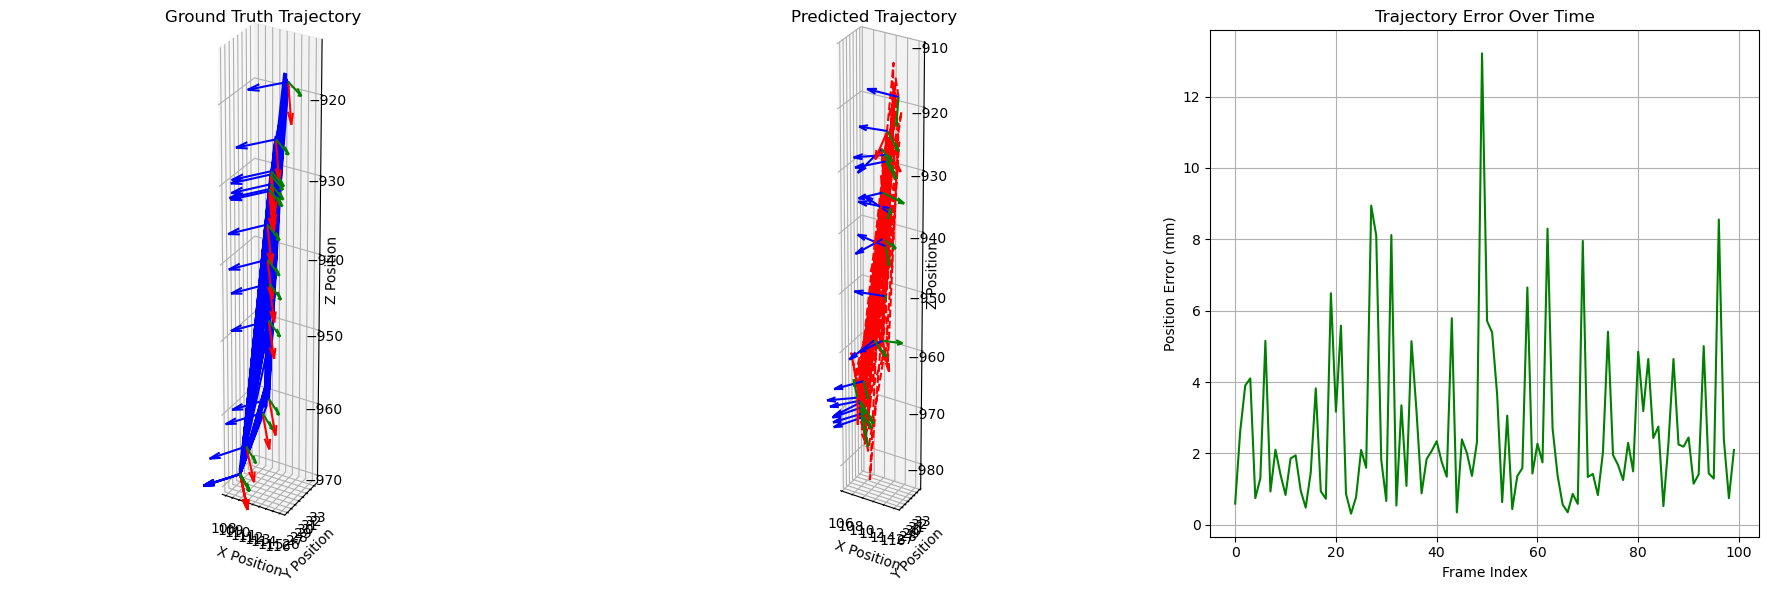

In [18]:
def plot_trajectory_with_orientation_and_error(
    predictions, targets, frame_stride=5, scale=5
):
    fig = plt.figure(figsize=(18, 6))

    # Subplot 1: Ground Truth Trajectory with Orientation Vectors
    ax1 = fig.add_subplot(131, projection="3d")
    ax1.plot(
        targets[:, 0],
        targets[:, 1],
        targets[:, 2],
        label="Ground Truth",
        color="b",
        linestyle="-",
    )
    for i in range(0, len(targets), frame_stride):
        pos = targets[i, :3]
        quat = targets[i, 3:]
        rot_matrix = R.from_quat(quat).as_matrix()
        axes = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, scale]])
        transformed_axes = rot_matrix @ axes.T + pos[:, np.newaxis]

        colors = ["r", "g", "b"]
        for j, color in enumerate(colors):
            ax1.quiver(
                pos[0],
                pos[1],
                pos[2],
                transformed_axes[0, j] - pos[0],
                transformed_axes[1, j] - pos[1],
                transformed_axes[2, j] - pos[2],
                color=color,
            )
    ax1.set_title("Ground Truth Trajectory")
    ax1.set_xlabel("X Position")
    ax1.set_ylabel("Y Position")
    ax1.set_zlabel("Z Position")
    ax1.set_box_aspect(
        [np.ptp(a) for a in [targets[:, 0], targets[:, 1], targets[:, 2]]]
    )

    # Subplot 2: Predicted Trajectory with Orientation Vectors
    ax2 = fig.add_subplot(132, projection="3d")
    ax2.plot(
        predictions[:, 0],
        predictions[:, 1],
        predictions[:, 2],
        label="Predicted",
        color="r",
        linestyle="--",
    )
    for i in range(0, len(predictions), frame_stride):
        pos = predictions[i, :3]
        quat = predictions[i, 3:]
        rot_matrix = R.from_quat(quat).as_matrix()
        axes = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, scale]])
        transformed_axes = rot_matrix @ axes.T + pos[:, np.newaxis]

        colors = ["r", "g", "b"]
        for j, color in enumerate(colors):
            ax2.quiver(
                pos[0],
                pos[1],
                pos[2],
                transformed_axes[0, j] - pos[0],
                transformed_axes[1, j] - pos[1],
                transformed_axes[2, j] - pos[2],
                color=color,
            )
    ax2.set_title("Predicted Trajectory")
    ax2.set_xlabel("X Position")
    ax2.set_ylabel("Y Position")
    ax2.set_zlabel("Z Position")
    ax2.set_box_aspect(
        [np.ptp(a) for a in [predictions[:, 0], predictions[:, 1], predictions[:, 2]]]
    )

    # Subplot 3: Trajectory Error
    ax3 = fig.add_subplot(133)
    trajectory_error = np.linalg.norm(predictions[:, :3] - targets[:, :3], axis=1)
    ax3.plot(trajectory_error, label="Trajectory Error", color="g")
    ax3.set_title("Trajectory Error Over Time")
    ax3.set_xlabel("Frame Index")
    ax3.set_ylabel("Position Error (mm)")
    ax3.grid(True)

    plt.tight_layout()
    plt.show()


# %%
# Plot the trajectories with orientation vectors and error
plot_trajectory_with_orientation_and_error(val_predictions, val_targets)

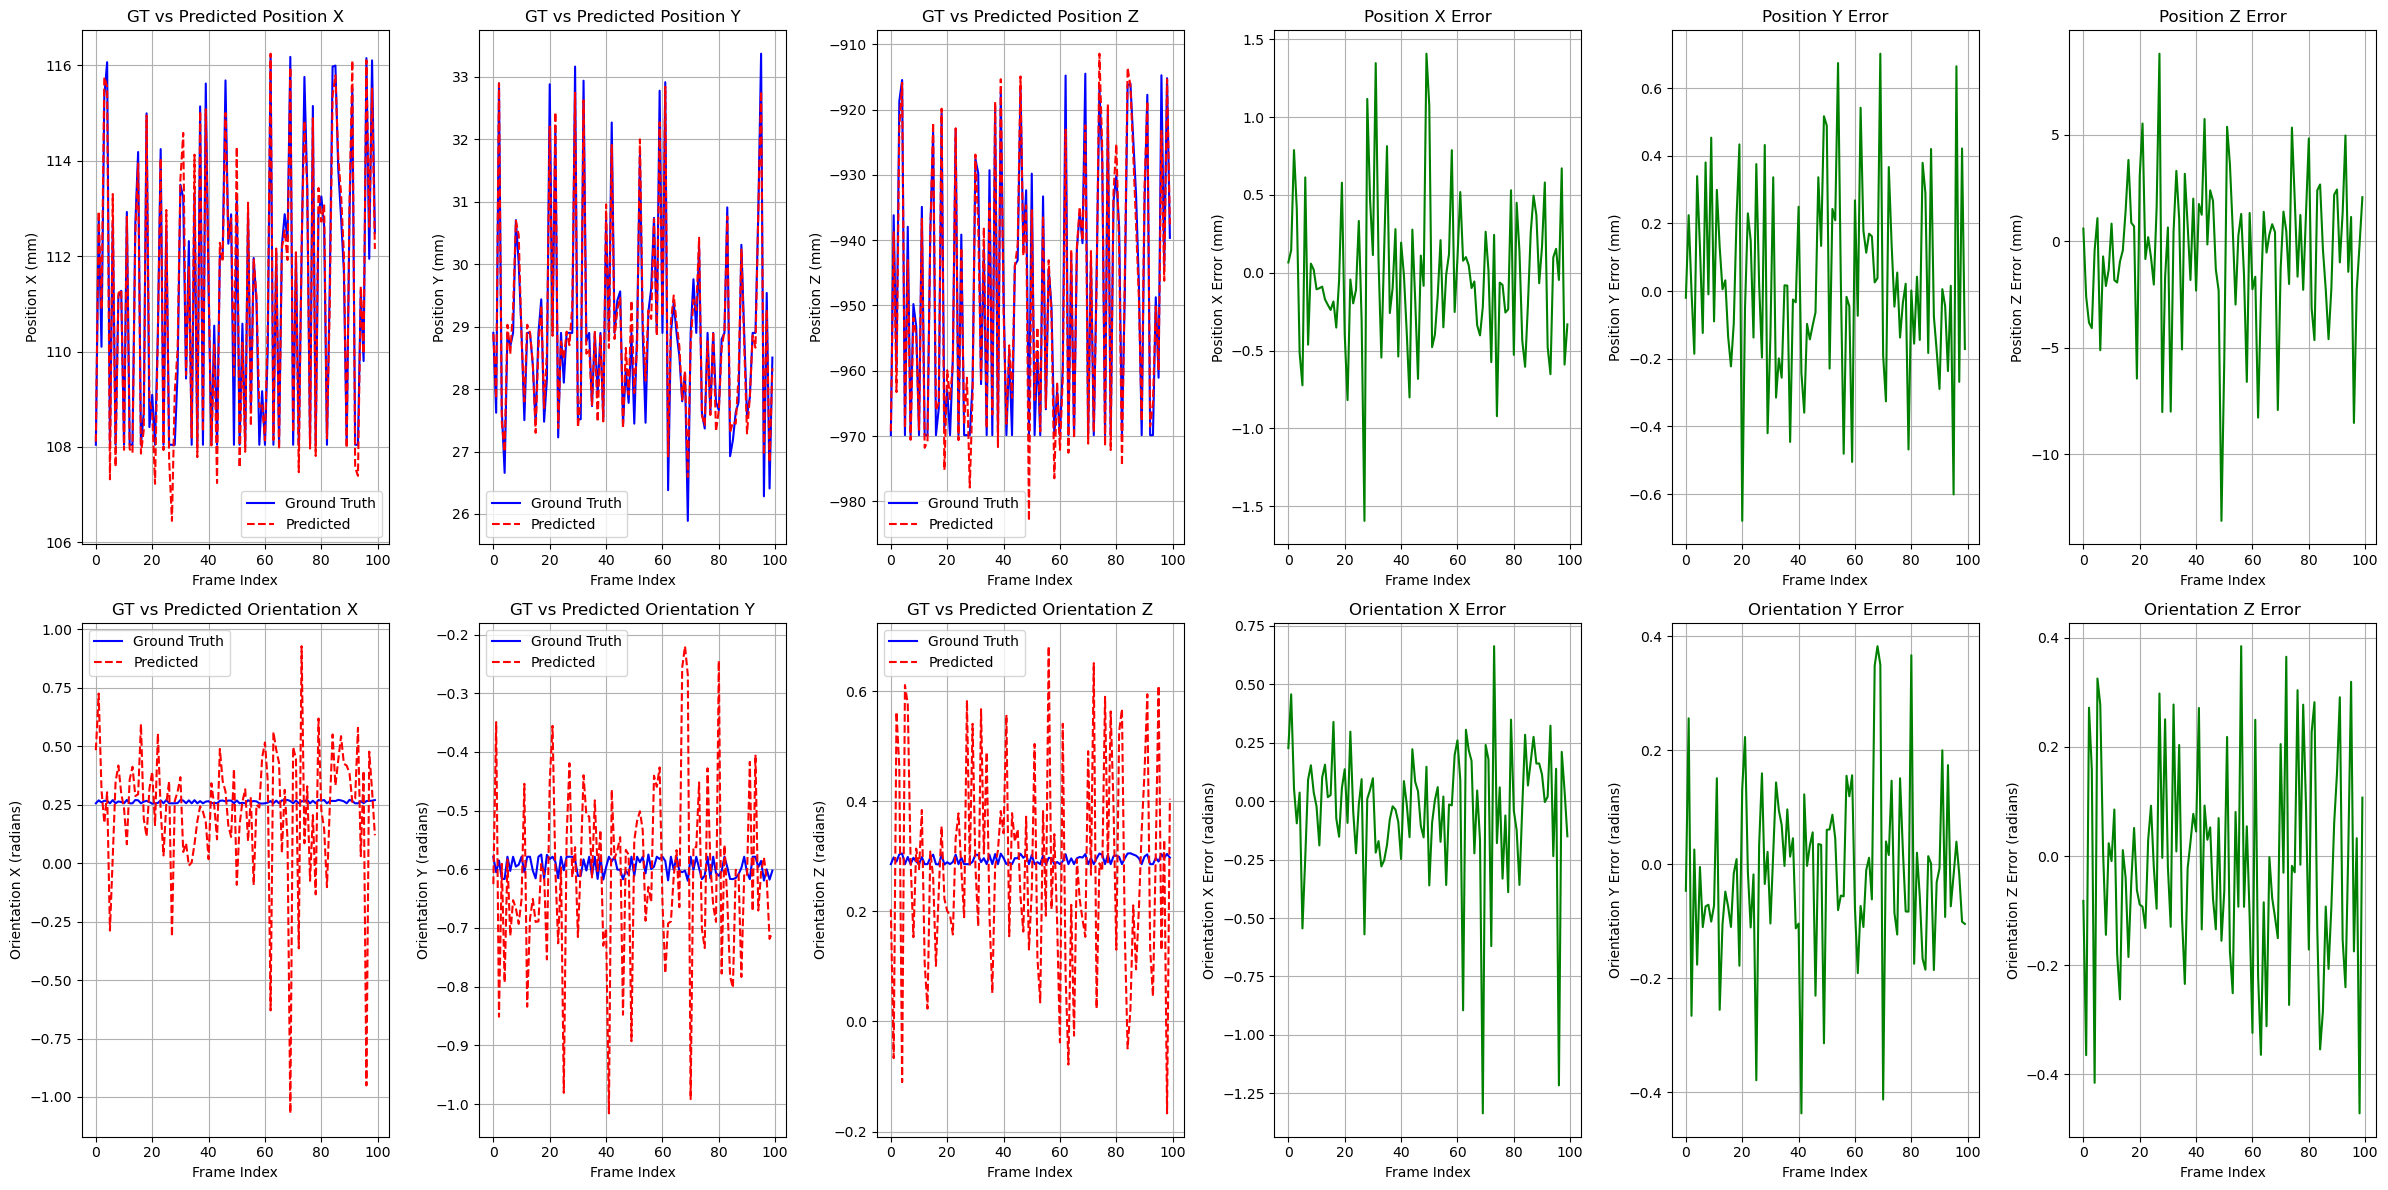

In [19]:
def plot_position_orientation_errors(predictions, targets):
    fig, axes = plt.subplots(2, 6, figsize=(24, 12))

    # Titles for position and orientation
    pos_titles = ["Position X", "Position Y", "Position Z"]
    orient_titles = ["Orientation X", "Orientation Y", "Orientation Z"]

    # Position plots (X, Y, Z)
    for i in range(3):
        # Ground Truth vs Predicted
        axes[0, i].plot(targets[:, i], label="Ground Truth", color="b")
        axes[0, i].plot(predictions[:, i], label="Predicted", color="r", linestyle="--")
        axes[0, i].set_title(f"GT vs Predicted {pos_titles[i]}")
        axes[0, i].set_xlabel("Frame Index")
        axes[0, i].set_ylabel(f"{pos_titles[i]} (mm)")
        axes[0, i].legend()
        axes[0, i].grid(True)

        # Error
        error = predictions[:, i] - targets[:, i]
        axes[0, i + 3].plot(error, label="Error", color="g")
        axes[0, i + 3].set_title(f"{pos_titles[i]} Error")
        axes[0, i + 3].set_xlabel("Frame Index")
        axes[0, i + 3].set_ylabel(f"{pos_titles[i]} Error (mm)")
        axes[0, i + 3].grid(True)

    # Orientation plots (X, Y, Z)
    for i in range(3):
        # Ground Truth vs Predicted
        axes[1, i].plot(targets[:, i + 4], label="Ground Truth", color="b")
        axes[1, i].plot(
            predictions[:, i + 4], label="Predicted", color="r", linestyle="--"
        )
        axes[1, i].set_title(f"GT vs Predicted {orient_titles[i]}")
        axes[1, i].set_xlabel("Frame Index")
        axes[1, i].set_ylabel(f"{orient_titles[i]} (radians)")
        axes[1, i].legend()
        axes[1, i].grid(True)

        # Error
        error = predictions[:, i + 4] - targets[:, i + 4]
        axes[1, i + 3].plot(error, label="Error", color="g")
        axes[1, i + 3].set_title(f"{orient_titles[i]} Error")
        axes[1, i + 3].set_xlabel("Frame Index")
        axes[1, i + 3].set_ylabel(f"{orient_titles[i]} Error (radians)")
        axes[1, i + 3].grid(True)

    plt.tight_layout()
    plt.show()


plot_position_orientation_errors(val_predictions, val_targets)

In [20]:
from scipy.spatial.transform import Rotation


def reconstruct_ground_truth_volume(df, probe_specs, voxel_size=0.5):
    frames = df["frame"].values
    positions = df[["ot_pos_x", "ot_pos_y", "ot_pos_z"]].values
    orientations = df[["ot_qw", "ot_qx", "ot_qy", "ot_qz"]].values

    # Probe specifications
    depth = probe_specs["depth"]  # mm (axial direction)
    width = probe_specs["width"]  # mm (lateral direction)
    axial_res = probe_specs["axial_res"]  # mm
    lateral_res = probe_specs["lateral_res"]  # mm
    slice_thickness = probe_specs["slice_thickness"]  # mm (elevational direction)
    marker_to_probe_bottom = probe_specs["marker_to_probe_bottom"]  # mm

    # Calculate scaling factors
    axial_scale = depth / 1000  # mm per pixel in axial direction
    lateral_scale = width / 657  # mm per pixel in lateral direction

    # Calculate volume bounds
    rotations = Rotation.from_quat(orientations[:, [1, 2, 3, 0]])

    # Define frame corners in probe coordinates (y: axial, x: lateral, z: elevational)
    frame_corners = np.array(
        [[0, 0, 0], [width, 0, 0], [0, depth, 0], [width, depth, 0]]
    )

    # Transform to align with optical tracker coordinates
    transform_matrix = np.array(
        [
            [0, 0, -1],  # Tracker X -> -Probe Z (elevational)
            [1, 0, 0],  # Tracker Y -> Probe X (lateral)
            [0, -1, 0],  # Tracker Z -> -Probe Y (axial)
        ]
    )

    frame_corners = frame_corners @ transform_matrix.T

    # Add offset for marker to probe bottom
    frame_corners[:, 2] += marker_to_probe_bottom

    all_corners = (
        np.einsum("ijk,lk->ilj", rotations.as_matrix(), frame_corners)
        + positions[:, np.newaxis, :]
    )
    min_corner = np.min(all_corners.reshape(-1, 3), axis=0)
    max_corner = np.max(all_corners.reshape(-1, 3), axis=0)

    # Initialize volume
    volume_shape = np.ceil((max_corner - min_corner) / voxel_size).astype(int) + 1
    volume = np.zeros(volume_shape, dtype=np.float32)
    counts = np.zeros(volume_shape, dtype=np.int32)

    # Create coordinate grid for frames
    x, y = np.meshgrid(np.arange(657) * lateral_scale, np.arange(1000) * axial_scale)
    frame_coords = np.stack((x, y, np.zeros_like(x)), axis=-1)

    # Transform frame coordinates to align with optical tracker
    frame_coords = frame_coords @ transform_matrix.T
    frame_coords[:, :, 2] += marker_to_probe_bottom

    print("Reconstructing ground truth volume...")
    for i, (frame, position, orientation) in enumerate(
        tqdm(zip(frames, positions, orientations), total=len(frames))
    ):
        # Convert frame to grayscale
        frame = np.mean(frame, axis=-1).astype(np.float32)

        # Transform frame coordinates to world space
        rotation = Rotation.from_quat(orientation[[1, 2, 3, 0]]).as_matrix()
        world_coords = np.einsum("ij,klj->kli", rotation, frame_coords) + position

        # Calculate voxel coordinates
        voxel_coords = np.round((world_coords - min_corner) / voxel_size).astype(int)

        # Filter out-of-bounds voxels
        mask = np.all((voxel_coords >= 0) & (voxel_coords < volume_shape), axis=2)
        valid_voxels = voxel_coords[mask]
        valid_intensities = frame[mask]

        # Update volume and counts
        np.add.at(volume, tuple(valid_voxels.T), valid_intensities)
        np.add.at(counts, tuple(valid_voxels.T), 1)

    # Average intensities and handle zero counts
    mask = counts > 0
    volume[mask] /= counts[mask]

    return volume, min_corner, voxel_size


# Probe specifications
probe_specs = {
    "depth": 50,  # mm (axial direction)
    "width": 38,  # mm (lateral direction, assuming 19 mm on each side of the center)
    "axial_res": 0.5,  # mm
    "lateral_res": 2,  # mm
    "slice_thickness": 5,  # mm (elevational direction)
    "marker_to_probe_bottom": 54,  # mm (approximate, to be refined)
}

# Reconstruct ground truth volume
ground_truth_volume, volume_origin, voxel_size = reconstruct_ground_truth_volume(
    df, probe_specs, voxel_size=0.1  # lower voxel size corresponds to higher resolution
)

print(f"Ground truth volume shape: {ground_truth_volume.shape}")
print(f"Volume origin: {volume_origin}")
print(f"Voxel size: {voxel_size} mm")

# Save the ground truth volume
np.save("ground_truth_volume.npy", np.flip(ground_truth_volume, axis=0))
print("Ground truth volume saved as 'ground_truth_volume.npy'")

# Save metadata
metadata = {
    "volume_origin": volume_origin.tolist(),
    "voxel_size": voxel_size,
    "probe_specs": probe_specs,
}
np.save("ground_truth_volume_metadata.npy", metadata)
print("Metadata saved as 'ground_truth_volume_metadata.npy'")

Reconstructing ground truth volume...


  0%|          | 0/500 [00:00<?, ?it/s]

Ground truth volume shape: (697, 715, 601)
Volume origin: [  44.0769405   -13.89386663 -969.06145428]
Voxel size: 0.1 mm
Ground truth volume saved as 'ground_truth_volume.npy'
Metadata saved as 'ground_truth_volume_metadata.npy'


In [29]:
def apply_constant_rotation(rotation_matrix, axes, angle_degrees):
    """Applies a constant rotation to the specified axes."""
    angle_radians = np.deg2rad(angle_degrees)
    rotation = np.eye(3)
    if "x" in axes:
        rotation = np.dot(Rotation.from_euler("x", angle_radians).as_matrix(), rotation)
    if "y" in axes:
        rotation = np.dot(Rotation.from_euler("y", angle_radians).as_matrix(), rotation)
    if "z" in axes:
        rotation = np.dot(Rotation.from_euler("z", angle_radians).as_matrix(), rotation)
    return np.dot(rotation_matrix, rotation)


def reconstruct_predicted_volume(
    frames,
    predicted_transforms,
    probe_specs,
    voxel_size=0.5,
    ignore_orientation=False,
    rotation_axes=None,
):
    # Extract translations and rotations from predicted transforms
    translations = predicted_transforms[:, :3]

    if ignore_orientation:
        # Use identity matrix if ignoring orientation
        rotations = np.tile(np.eye(3), (len(translations), 1, 1))
    else:
        # Convert quaternion to rotation matrix
        quaternions = predicted_transforms[
            :, 3:
        ]  # Assuming quaternions in the form [qw, qx, qy, qz]
        rotations = Rotation.from_quat(quaternions).as_matrix()

    if rotation_axes:
        # Apply a constant rotation of 90 degrees to the specified axes
        rotations = np.array(
            [apply_constant_rotation(rot, rotation_axes, 90) for rot in rotations]
        )

    # Probe specifications
    depth = probe_specs["depth"]
    width = probe_specs["width"]
    marker_to_probe_bottom = probe_specs["marker_to_probe_bottom"]

    # Calculate scaling factors
    axial_scale = depth / frames.shape[1]
    lateral_scale = width / frames.shape[2]

    # Calculate volume bounds
    frame_corners = np.array(
        [[0, 0, 0], [width, 0, 0], [0, depth, 0], [width, depth, 0]]
    )
    transform_matrix = np.array(
        [
            [0, 0, -1],
            [1, 0, 0],
            [0, -1, 0],
        ]
    )
    frame_corners = frame_corners @ transform_matrix.T
    frame_corners[:, 2] += marker_to_probe_bottom

    all_corners = (
        np.einsum("ijk,lk->ilj", rotations, frame_corners)
        + translations[:, np.newaxis, :]
    )
    min_corner = np.min(all_corners.reshape(-1, 3), axis=0)
    max_corner = np.max(all_corners.reshape(-1, 3), axis=0)

    # Initialize volume
    volume_shape = np.ceil((max_corner - min_corner) / voxel_size).astype(int) + 1
    volume = np.zeros(volume_shape, dtype=np.float32)
    counts = np.zeros(volume_shape, dtype=np.int32)

    # Create coordinate grid for frames
    x, y = np.meshgrid(
        np.arange(frames.shape[2]) * lateral_scale,
        np.arange(frames.shape[1]) * axial_scale,
    )
    frame_coords = np.stack((x, y, np.zeros_like(x)), axis=-1)
    frame_coords = frame_coords @ transform_matrix.T
    frame_coords[:, :, 2] += marker_to_probe_bottom

    print("Reconstructing predicted volume...")
    for i, (frame, translation, rotation) in enumerate(
        tqdm(zip(frames, translations, rotations), total=len(frames))
    ):
        # Ensure frame is 2D (height x width)
        if frame.ndim == 3:
            frame = np.mean(frame, axis=-1).astype(np.float32)

        # Transform frame coordinates to world space
        world_coords = np.einsum("ij,klj->kli", rotation, frame_coords) + translation

        # Calculate voxel coordinates
        voxel_coords = np.round((world_coords - min_corner) / voxel_size).astype(int)

        # Filter out-of-bounds voxels
        mask = np.all((voxel_coords >= 0) & (voxel_coords < volume_shape), axis=2)
        valid_voxels = voxel_coords[mask]
        valid_intensities = frame[mask]

        # Update volume and counts
        np.add.at(volume, tuple(valid_voxels.T), valid_intensities)
        np.add.at(counts, tuple(valid_voxels.T), 1)

    # Average intensities and handle zero counts
    mask = counts > 0
    volume[mask] /= counts[mask]

    return volume, min_corner, voxel_size


# Ensure lists to store all frames and predictions
all_frames = []
all_predictions = []

# Use the trained model to make predictions
with torch.no_grad():
    for frames, imu_data, _ in val_loader:
        frames = frames.to(device)
        imu_data = imu_data.to(device)
        outputs = model(frames, imu_data)

        # Append the numpy arrays for frames and predictions
        all_frames.append(frames.cpu().numpy())
        all_predictions.append(outputs.cpu().numpy())

# Concatenate lists into 2D numpy arrays
all_frames = np.concatenate(all_frames, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

# Reconstruct the predicted volume with a 90-degree rotation around the 'z' axis
predicted_volume, volume_origin, voxel_size = reconstruct_predicted_volume(
    all_frames[:, 0],  # Use only the first frame of each sequence
    all_predictions,  # Use the full prediction array
    probe_specs,
    voxel_size=0.1,
    ignore_orientation=True,  # Use predicted orientations
    rotation_axes=["y"],  # Apply a 90-degree rotation around the z-axis
)


print(f"Predicted volume shape: {predicted_volume.shape}")
print(f"Volume origin: {volume_origin}")
print(f"Voxel size: {voxel_size} mm")

# Save the predicted volume
np.save("predicted_volume.npy", predicted_volume)
print("Predicted volume saved as 'predicted_volume.npy'")

# Save metadata
metadata = {
    "volume_origin": volume_origin.tolist(),
    "voxel_size": voxel_size,
    "probe_specs": probe_specs,
}
np.save("predicted_volume_metadata.npy", metadata)
print("Metadata saved as 'predicted_volume_metadata.npy'")

Reconstructing predicted volume...


  0%|          | 0/100 [00:00<?, ?it/s]

Predicted volume shape: (599, 445, 717)
Volume origin: [ 110.45036316   26.59061241 -982.98504639]
Voxel size: 0.1 mm
Predicted volume saved as 'predicted_volume.npy'
Metadata saved as 'predicted_volume_metadata.npy'
